In [1]:
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import numpy as np

In [2]:
import statsmodels.api as sma
from sklearn.base import BaseEstimator, RegressorMixin

class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if self.fit_intercept:
            X = sma.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
        return self
    def predict(self, X):
        if self.fit_intercept:
            X = sma.add_constant(X)
        return self.results_.predict(X)

In [3]:
def create_Ndose_period_lst(freq,range_end):
    lst_1dose=[]
    lst_2dose=[]
    lst_3dose=[]
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_1dose.append('1dose_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_1dose.append('1dose_{}m+'.format(st_lab))
    
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_2dose.append('2dose_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_2dose.append('2dose_{}m+'.format(st_lab))
    
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_3dose.append('3dose_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_3dose.append('3dose_{}m+'.format(st_lab))
    return lst_1dose,lst_2dose,lst_3dose

In [4]:
def create_overall_period_lst(freq,range_end):
    lst_overall=[]
    for st_lab in range(1,range_end+1,freq):
        et_lab = st_lab + freq -1 
        lst_overall.append('overall_{}_{}m'.format(st_lab,et_lab))
        st_lab = et_lab + 1
    lst_overall.append('overall_{}m+'.format(st_lab))
    return lst_overall #_1dose,lst_2dose,lst_3dose

In [6]:
def feature_extraction_st(df,Country_lst,use_lst,start_date,end_date,vax_data_freq,st_per1,st_per2,st_per3):
    #['max_1st_rate','max_2nd_rate','max_3rd_rate']
    new_df = pd.DataFrame(columns=use_lst)
    for Countryname in Country_lst : 
        tmp_df=df[df['location']==Countryname].reset_index(drop=True)
        
        tmp_df['max_1st_rate'] = tmp_df['people_vaccinated_per_hundred'].max()
        tmp_df['max_2nd_rate'] = tmp_df['people_fully_vaccinated_per_hundred'].max()
        tmp_df['max_3rd_rate'] = tmp_df['total_boosters_per_hundred'].max()
        
        st_1dose = tmp_df[tmp_df['people_vaccinated_per_hundred']>st_per1]['date'].iloc[0]
        st_2dose = tmp_df[tmp_df['people_fully_vaccinated_per_hundred']>st_per2]['date'].iloc[0]
        st_3dose = tmp_df[tmp_df['total_boosters_per_hundred']>st_per3]['date'].iloc[0]
        #total_boosters_per_hundred
        print(Countryname,st_1dose,st_2dose,st_3dose)

        dict_1dose={}
        st = datetime.strptime(st_1dose,'%Y-%m-%d')
        for i in range(len(lst_1dose))[:-1]:
            et = st + relativedelta(months=+3) # + relativedelta(days=+1)
            dict_1dose[lst_1dose[i]] = (str(st)[:10],str(et)[:10])
            st = et + relativedelta(days=+vax_data_freq)
        et = st + relativedelta(months=+24) # + relativedelta(days=+1)
        dict_1dose[lst_1dose[i+1]] = (str(st)[:10],str(et)[:10])

        dict_2dose={}
        st = datetime.strptime(st_2dose,'%Y-%m-%d')
        for i in range(len(lst_2dose))[:-1]:
            et = st + relativedelta(months=+vax_data_freq) # + relativedelta(days=+1)
            dict_2dose[lst_2dose[i]] = (str(st)[:10],str(et)[:10])
            st = et + relativedelta(days=+1)
        et = st + relativedelta(months=+24) # + relativedelta(days=+1)
        dict_2dose[lst_2dose[i+1]] = (str(st)[:10],str(et)[:10])

        dict_3dose={}
        st = datetime.strptime(st_3dose,'%Y-%m-%d')
        for i in range(len(lst_3dose))[:-1]:
            et = st + relativedelta(months=+vax_data_freq) # + relativedelta(days=+1)
            dict_3dose[lst_3dose[i]] = (str(st)[:10],str(et)[:10])
            st = et + relativedelta(days=+1)
        et = st + relativedelta(months=+24) # + relativedelta(days=+1)
        dict_3dose[lst_3dose[i+1]] = (str(st)[:10],str(et)[:10])
        # labeling catagories
        tmp_df['1dose_period']='1st_Null'
        for tmp_period in dict_1dose.keys():
            tmp_st=dict_1dose[tmp_period][0]
            tmp_et=dict_1dose[tmp_period][1]
            tmp_df['1dose_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period

        tmp_df['2dose_period']='2nd_Null'
        for tmp_period in dict_2dose.keys():
            tmp_st=dict_2dose[tmp_period][0]
            tmp_et=dict_2dose[tmp_period][1]
            tmp_df['2dose_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period

        tmp_df['3dose_period']='3rd_Null'
        for tmp_period in dict_3dose.keys():
            tmp_st=dict_3dose[tmp_period][0]
            tmp_et=dict_3dose[tmp_period][1]
            tmp_df['3dose_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period

        one_hot = pd.get_dummies(tmp_df['1dose_period'])
        # Drop column 1dose_period as it is now encoded
        tmp_df = tmp_df.drop('1dose_period',axis = 1)
        # Join the encoded df
        tmp_df = tmp_df.join(one_hot)

        one_hot = pd.get_dummies(tmp_df['2dose_period'])
        # Drop column 2dose_period as it is now encoded
        tmp_df = tmp_df.drop('2dose_period',axis = 1)
        # Join the encoded df
        tmp_df = tmp_df.join(one_hot)

        one_hot = pd.get_dummies(tmp_df['3dose_period'])
        # Drop column 3dose_period as it is now encoded
        tmp_df = tmp_df.drop('3dose_period',axis = 1)
        # Join the encoded df
        tmp_df = tmp_df.join(one_hot)
        #
        plt_df = pd.DataFrame(columns=use_lst)
        ####################################################
        #new_df = pd.DataFrame(columns=use_lst)
        plt_df = pd.concat([plt_df,tmp_df])[use_lst]
        plt_df = plt_df.fillna(method='bfill').dropna(subset=['new_deaths','new_deaths_smoothed','excess_mortality']).fillna(int(0))
        plt_df = plt_df[plt_df['date']>=start_date].reset_index(drop=True)
        plt_df = plt_df[plt_df['date']<=end_date].reset_index(drop=True)
        if plt_df['excess_mortality'].unique().shape[0]<=5:
            print('****skipping {} data for lack of excess_mortality.'.format(Countryname))
            continue
        if plt_df['new_deaths_smoothed'].unique().shape[0]<=10:
            print('****skipping {} data for lack of new_deaths_smoothed.'.format(Countryname))
            continue
        if plt_df['new_deaths_smoothed'].max() == 0:
            continue
        
        plt_df['excess_mortality_Norm'] = plt_df['excess_mortality']/plt_df['excess_mortality'].max()
        plt_df['new_deaths_smoothed_Norm'] = plt_df['new_deaths_smoothed']/plt_df['new_deaths_smoothed'].max()
        # re-estimate excess mortality
        plt_df['re_est_ex_mortality'] = (plt_df['excess_mortality']+100)/(plt_df['excess_mortality'].min()+100)-1
        plt_df['re_est_ex_mortality_Norm'] = plt_df['re_est_ex_mortality']/plt_df['re_est_ex_mortality'].max()
        plt_df['weekday'] = pd.to_datetime(plt_df['date']).dt.day_name().tolist()
        
        new_df = pd.concat([new_df,plt_df]).reset_index(drop=True)
        #print(dict_1dose,dict_2dose,dict_3dose)
    return new_df

In [7]:
def feature_extraction_overall(df,Country_lst,use_lst,start_date_data,start_date_ref,end_date_data,vax_data_freq):
    new_df = pd.DataFrame(columns=use_lst)
    for Countryname in Country_lst : 
        tmp_df=df[df['location']==Countryname].reset_index(drop=True)
        
        dict_overall={}
        st = datetime.strptime(start_date_ref,'%Y-%m-%d')
        for i in range(len(lst_overall))[:-1]:
            et = st + relativedelta(months=+3) # + relativedelta(days=+1)
            dict_overall[lst_overall[i]] = (str(st)[:10],str(et)[:10])
            st = et + relativedelta(days=+vax_data_freq)
        et = st + relativedelta(months=+24) # + relativedelta(days=+1)
        dict_overall[lst_overall[i+1]] = (str(st)[:10],str(et)[:10])

        # labeling catagories
        tmp_df['overall_period']='overall_Null'
        for tmp_period in dict_overall.keys():
            tmp_st=dict_overall[tmp_period][0]
            tmp_et=dict_overall[tmp_period][1]
            tmp_df['overall_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period

        one_hot = pd.get_dummies(tmp_df['overall_period'])
        # Drop column 1dose_period as it is now encoded
        tmp_df = tmp_df.drop('overall_period',axis = 1)
        # Join the encoded df
        tmp_df = tmp_df.join(one_hot)
        
        plt_df = pd.DataFrame(columns=use_lst)
        ####################################################
        plt_df = pd.concat([plt_df,tmp_df])[use_lst]
        plt_df = plt_df.fillna(method='bfill').dropna(subset=['new_deaths','new_deaths_smoothed','excess_mortality']).fillna(int(0))
        plt_df = plt_df[plt_df['date']>=start_date_data].reset_index(drop=True)
        plt_df = plt_df[plt_df['date']<=end_date_data].reset_index(drop=True)
        if plt_df['excess_mortality'].unique().shape[0]<=5:
            print('****skipping {} data for lack of excess_mortality.'.format(Countryname))
            continue
        if plt_df['new_deaths_smoothed'].unique().shape[0]<=10:
            print('****skipping {} data for lack of new_deaths_smoothed.'.format(Countryname))
            continue
        if plt_df['new_deaths_smoothed'].max() == 0:
            continue
        
        plt_df['excess_mortality_Norm'] = plt_df['excess_mortality']/plt_df['excess_mortality'].max()
        plt_df['new_deaths_smoothed_Norm'] = plt_df['new_deaths_smoothed']/plt_df['new_deaths_smoothed'].max()
        # re-estimate excess mortality
        plt_df['re_est_ex_mortality'] = (plt_df['excess_mortality']+100)/(plt_df['excess_mortality'].min()+100)-1
        plt_df['re_est_ex_mortality_Norm'] = plt_df['re_est_ex_mortality']/plt_df['re_est_ex_mortality'].max()
        plt_df['weekday'] = pd.to_datetime(plt_df['date']).dt.day_name().tolist()
        
        new_df = pd.concat([new_df,plt_df]).reset_index(drop=True)
        #print(plt_df.tail(50))
    return new_df

In [9]:
from sklearn import datasets, linear_model
import statsmodels.api as sma
from sklearn.metrics import mean_squared_error

def run_new_model(new_df,mdl_x_lst,mdl_y_lst):
    print(new_df[mdl_x_lst + mdl_y_lst].corr())
    x = new_df[mdl_x_lst].values.astype('float64')
    y = new_df[mdl_y_lst].values.astype('float64')

    # Linear Regression
    X2  = sma.add_constant(x)

    est  = sma.OLS(y, X2)
    lr_mdl  = est.fit()
    y_pred = lr_mdl.predict(X2)
    rmse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    
    print('[{}] Self-Rmse for {} is : {}\nSelf-R2 is : {}'.format('LR_MDL','All',rmse,r2))
    r2_score_lst = cross_val_score(SMWrapper(sma.OLS), x, y, scoring='r2')
    mean_r2_score = np.mean(r2_score_lst)
    tmp_lst = cross_val_score(SMWrapper(sma.OLS), x, y, scoring='neg_mean_squared_error') #neg_root_mean_squared_error  
    rmse_lst = [x*(-1) for x in tmp_lst]
    mean_rmse = np.mean(rmse_lst)
    print('Cross-validataion R2 : {}.'.format(r2_score_lst))
    print('\033[1m' + 'Cross-validataion R2 average : {}.'.format(mean_r2_score) + '\033[0m')
    print('Cross-validataion mse : {}.'.format(rmse_lst))
    print('\033[1m' + 'Cross-validataion mse average : {}.'.format(mean_rmse) + '\033[0m')

    #print(lr_mdl.summary())

    # create result DataFrame
    res_df = pd.DataFrame()
    res_df['params'] = mdl_x_lst
    res_df['linear_weights'] = np.around(lr_mdl.params[1:], decimals=6, out=None)  

    res_df['p_value'] = np.around(lr_mdl.pvalues[1:], decimals=6, out=None)  
    print('[{}] Intercept is : {}'.format('LR_MDL',np.around(lr_mdl.params[0], decimals=6, out=None)))
    print('\033[1m' + 'LR model coeffecients.' + '\033[0m')
    print(res_df)
    return lr_mdl, res_df, mean_r2_score, mean_rmse


In [10]:
from sklearn import datasets, linear_model
import statsmodels.api as sma
from sklearn.metrics import mean_squared_error

def run_silent_model(new_df,mdl_x_lst,mdl_y_lst):
    print(new_df[mdl_x_lst + mdl_y_lst].corr())
    x = new_df[mdl_x_lst].values.astype('float64')
    y = new_df[mdl_y_lst].values.astype('float64')

    # Linear Regression
    X2  = sma.add_constant(x)

    est  = sma.OLS(y, X2)
    lr_mdl  = est.fit()
    y_pred = lr_mdl.predict(X2)
    rmse = mean_squared_error(y,y_pred)
    r2 = r2_score(y,y_pred)
    
    r2_score_lst = cross_val_score(SMWrapper(sma.OLS), x, y, scoring='r2')
    mean_r2_score = np.mean(r2_score_lst)
    tmp_lst = cross_val_score(SMWrapper(sma.OLS), x, y, scoring='neg_mean_squared_error')  
    rmse_lst = [x*(-1) for x in tmp_lst]
    mean_rmse = np.mean(rmse_lst)
    #print(lr_mdl.summary())

    # create result DataFrame (62 countries)
    res_df = pd.DataFrame()
    res_df['params'] = mdl_x_lst
    res_df['linear_weights'] = np.around(lr_mdl.params[1:], decimals=6, out=None)  #result.params[1:]

    res_df['p_value'] = np.around(lr_mdl.pvalues[1:], decimals=6, out=None) # result.pvalues[1:] #p_val
    print('[{}] Intercept is : {}'.format('LR_MDL',np.around(lr_mdl.params[0], decimals=6, out=None)))
    print('\033[1m' + 'LR model coeffecients.' + '\033[0m')
    print(res_df)
    return lr_mdl, res_df, mean_r2_score, mean_rmse



In [13]:
def plot_vax_rate(df,Countryname):
    tmp_df=df[df['location']==Countryname].reset_index(drop=True)
    # fix missing values
    for i in range(1,tmp_df.shape[0]):
        if np.isnan(tmp_df['people_vaccinated_per_hundred'][i]):
            tmp_df['people_vaccinated_per_hundred'][i] = tmp_df['people_vaccinated_per_hundred'][i-1]
        if np.isnan(tmp_df['people_fully_vaccinated_per_hundred'][i]):
            tmp_df['people_fully_vaccinated_per_hundred'][i]= tmp_df['people_fully_vaccinated_per_hundred'][i-1]
        if np.isnan(tmp_df['total_boosters_per_hundred'][i]):
            tmp_df['total_boosters_per_hundred'][i] = tmp_df['total_boosters_per_hundred'][i-1]


    save_path = 'results/Vax_rate/' + Countryname + '/'
    os.makedirs(save_path,exist_ok=True)

    fig_size=(10,5)
    n_dpi=120

    fig,ax = plt.subplots()
    fmt = mdates.MonthLocator(interval=1)
    ax.xaxis.set_major_locator(fmt)

    plt.plot(tmp_df['date'],tmp_df['people_vaccinated_per_hundred'],color='green', alpha=0.2)
    plt.plot(tmp_df['date'],tmp_df['people_fully_vaccinated_per_hundred'],color='green', alpha=0.4)
    plt.plot(tmp_df['date'],tmp_df['total_boosters_per_hundred'],color='green', alpha=0.6)
    ax.tick_params(axis='x', labelrotation=45)

    ax.fill_between(tmp_df['date'], tmp_df['people_vaccinated_per_hundred'],0, color='green', alpha=0.2)
    ax.fill_between(tmp_df['date'],tmp_df['people_fully_vaccinated_per_hundred'], 0, color='green', alpha=0.4)
    ax.fill_between(tmp_df['date'], tmp_df['total_boosters_per_hundred'], 0, color='green', alpha=0.6)

    fig.set_dpi(n_dpi)
    fig.set_size_inches(fig_size)
    ax.legend(['1st_dose_rate','2nd_dose_rate','3rd_dose_rate'],loc='upper left',fontsize=10)
    plt.title('{} Vaccination Rate'.format(Countryname),fontsize=20) 
    plt.tight_layout()
    fig.savefig(' '.join([save_path,'{}_Vaccination_Rate'.format(Countryname)])+str(fig_size)+'.png',facecolor='white', transparent=False) #' '.join([save_path,'【All causes death risk('+EN2CN[sex]+')】',EN2CN[v_status],'VS Unvaccinated'])+str(fig_size)+'.png',facecolor='white', transparent=False)


In [81]:
def cal_ex_death_by_covid_vax(df,lr_mdl,Countryname,vax_var_lst,start_date):
    tmp_df = df[df['location']==Countryname].reset_index(drop=True)
    tmp_df = tmp_df[tmp_df['date']>=start_date].reset_index(drop=True)
    ex_death_covid = tmp_df['new_deaths_smoothed'].mean()/tmp_df['new_deaths_smoothed'].max()*lr_mdl.params[1] ##.shape
    x = tmp_df.iloc[-1][vax_var_lst].values.astype('float64')
    ex_death_vax = np.dot(lr_mdl.params[10:],x)
    return ex_death_covid,ex_death_vax

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os 
from datetime import datetime
from dateutil.relativedelta import relativedelta

plt.rcParams['font.family']='Hiragino Maru Gothic Pro' #'sans-serif' #


In [19]:
# https://covid.ourworldindata.org/data/owid-covid-data.csv
os.makedirs('data',exist_ok=True)
#! curl https://covid.ourworldindata.org/data/owid-covid-data.csv > 'data/owid-covid-data-230321.csv'
#in_csv='data/owid-covid-data-230321.csv'
in_csv='data/owid-covid-data-230213.csv'
#in_csv='data/owid-covid-data-1214.csv'
df=pd.read_csv(in_csv,engine='python')

In [27]:
in_csv_1214='data/owid-covid-data-1214.csv'
df_1214=pd.read_csv(in_csv_1214,engine='python')


## Hparam selection : filtering out countries with low booster rate (booster_per_th)
create use_Country_lst

In [20]:
vax_rate_dic={}
# 'Sweden','Malta', shows partial record for 3rd dose vaccination rate
#'Sweden','Malta','Mexico','Brunei','French Polynesia','Mauritius','Mongolia','New Caledonia','Qatar','Seychelles',
#rm_vax_Country_lst = ['Sweden','Brunei','French Polynesia','Malta','Mauritius','Mexico','Mongolia','New Caledonia','Qatar','Seychelles',]
rm_Country_lst = ['Sweden','Malta','Mexico','Brunei','French Polynesia','Mauritius','Mongolia','New Caledonia','Qatar','Seychelles','Africa','Asia','Europe','European Union','High income','Low income','Lower middle income','North America','South America','Upper middle income','World','Western Sahara','Oceania']
booster_per_lst = []

for Countryname in df.location.unique().tolist():
    if Countryname in rm_Country_lst : continue 
    tmp_df=df[df['location']==Countryname].reset_index(drop=True)
    if tmp_df['total_boosters_per_hundred'].max()>0:
        booster_per_lst.append(tmp_df['total_boosters_per_hundred'].max()) #vax_rate_dic[Countryname] = [tmp_df['people_vaccinated_per_hundred'].max(),tmp_df['people_fully_vaccinated_per_hundred'].max(),tmp_df['total_boosters_per_hundred'].max()]

booster_per_th = np.median(booster_per_lst)
use_Country_lst = []

for Countryname in df.location.unique().tolist():
    if Countryname in rm_Country_lst : continue 
    tmp_df=df[df['location']==Countryname].reset_index(drop=True)
    if tmp_df['total_boosters_per_hundred'].max() >= booster_per_th :
        vax_rate_dic[Countryname] = [tmp_df['people_vaccinated_per_hundred'].max(),tmp_df['people_fully_vaccinated_per_hundred'].max(),tmp_df['total_boosters_per_hundred'].max()]
        use_Country_lst.append(Countryname)



In [92]:
# lower than 3rd dose threshold 
Country_lt_th_lst = []

for Countryname in df.location.unique().tolist():
    if Countryname in rm_Country_lst : continue 
    tmp_df=df[df['location']==Countryname].reset_index(drop=True)
    if tmp_df['total_boosters_per_hundred'].max() < booster_per_th :
        vax_rate_dic[Countryname] = [tmp_df['people_vaccinated_per_hundred'].max(),tmp_df['people_fully_vaccinated_per_hundred'].max(),tmp_df['total_boosters_per_hundred'].max()]
        Country_lt_th_lst.append(Countryname)

In [94]:
booster_per_th,len(use_Country_lst),len(Country_lt_th_lst)

(27.38, 96, 96)

In [24]:
len(Country_lt_th_lst)

96

# data processing

## from 0.0%

In [25]:
# used UK data from df_1214 instead
use_Country_lst
use_Country_lst_rm_UK = [x for x in use_Country_lst if x not in ['United Kingdom']]

In [95]:
# extract UK data from 2022-12-14 data
st_per1 = 0.0 #0.5 #1.0 #
st_per2 = 0.0 #0.5 #1.0 #
st_per3 = 0.5 # 1.0 #0.0
freq = 3 #3

# creating labels of catetorical classes
range_end = 12
lst_1dose,lst_2dose,lst_3dose=create_Ndose_period_lst(freq,range_end)
lst_max_dose_rate = ['max_1st_rate','max_2nd_rate','max_3rd_rate']

use_lst = ['location','date','new_deaths','new_deaths_smoothed','excess_mortality'] + lst_1dose + lst_2dose + lst_3dose + lst_max_dose_rate
new_df_UK = pd.DataFrame(columns=use_lst)
start_date = '2020-12-01'
end_date = '2023-03-31'
new_df_UK = feature_extraction_st(df_1214,['United Kingdom'],use_lst,start_date,end_date, freq,st_per1,st_per2,st_per3) # 62 countries

United Kingdom 2021-01-10 2021-01-10 2021-09-30


/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_30417/3474018985.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['1dose_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period
/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_30417/3474018985.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['2dose_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period
/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_30417/3474018985.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

In [96]:
st_per1 = 0.0 #0.5 #1.0 #
st_per2 = 0.0 #0.5 #1.0 #
st_per3 = 0.5 # 1.0 #0.0

freq = 3 #3

# creating labels of catetorical classes
range_end = 12
lst_1dose,lst_2dose,lst_3dose=create_Ndose_period_lst(freq,range_end)
lst_max_dose_rate = ['max_1st_rate','max_2nd_rate','max_3rd_rate']

use_lst = ['location','date','new_deaths','new_deaths_smoothed','excess_mortality'] + lst_1dose + lst_2dose + lst_3dose + lst_max_dose_rate
new_df = pd.DataFrame(columns=use_lst)
#start_date = '2021-01-01'
start_date = '2020-12-01'
#start_date = '2020-09-01'
end_date = '2023-03-31'
#end_date = '2023-01-01'
#end_date = '2022-12-31'

new_df = feature_extraction_st(df,use_Country_lst_rm_UK,use_lst,start_date,end_date, freq,st_per1,st_per2,st_per3) # 55 countries


new_df.shape


Andorra 2021-01-25 2021-03-08 2021-12-12
****skipping Andorra data for lack of new_deaths_smoothed.
Argentina 2020-12-29 2021-01-19 2021-11-04
****skipping Argentina data for lack of excess_mortality.
Australia 2021-02-22 2021-03-17 2021-11-05


/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_30417/3474018985.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['1dose_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period
/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_30417/3474018985.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['2dose_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period
/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_30417/3474018985.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

Austria 2020-12-27 2021-01-18 2021-09-23
Azerbaijan 2021-02-06 2021-04-01 2021-11-08
Bahrain 2020-12-23 2021-03-06 2021-12-21
****skipping Bahrain data for lack of excess_mortality.
Bangladesh 2021-02-07 2021-04-08 2022-01-19
****skipping Bangladesh data for lack of excess_mortality.
Belarus 2021-02-18 2021-03-12 2021-12-12
****skipping Belarus data for lack of excess_mortality.
Belgium 2020-12-30 2021-01-18 2021-09-24
Bermuda 2021-01-16 2021-02-06 2021-11-05
Bhutan 2021-03-27 2021-07-05 2022-01-30
****skipping Bhutan data for lack of excess_mortality.
Brazil 2021-01-19 2021-02-06 2021-09-30
Cambodia 2021-02-12 2021-02-28 2021-08-11
****skipping Cambodia data for lack of excess_mortality.
Canada 2020-12-16 2021-01-08 2021-10-01
Cayman Islands 2021-02-04 2021-02-04 2022-03-25
****skipping Cayman Islands data for lack of excess_mortality.
Chile 2020-12-25 2021-01-13 2021-08-12
China 2021-06-10 2021-08-12 2021-11-05
****skipping China data for lack of excess_mortality.
Colombia 2021-03-13

(37135, 28)

In [97]:
new_df = pd.concat([new_df,new_df_UK]).reset_index(drop=True)

In [35]:
freq = 3 

# creating labels of catetorical classes
range_end = 21 
lst_overall=create_overall_period_lst(freq,range_end)

use_lst = ['location','date','new_deaths','new_deaths_smoothed','excess_mortality'] + lst_overall #lst_1dose + lst_2dose + lst_3dose
new_df_overall = pd.DataFrame(columns=use_lst)
start_date_ref = '2021-01-01'
start_date_data = '2020-12-01'
#start_date_data = '2020-09-01'
end_date = '2023-03-31'
#end_date = '2023-01-01'
#end_date = '2022-12-31'

new_df_overall = feature_extraction_overall(df,use_Country_lst,use_lst,start_date_data,start_date_ref, end_date, freq) # 62 countries

/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_30417/2407692322.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['overall_period'][(tmp_df['date']>=tmp_st) & (tmp_df['date']<=tmp_et)]=tmp_period


****skipping Andorra data for lack of new_deaths_smoothed.
****skipping Argentina data for lack of excess_mortality.
****skipping Bahrain data for lack of excess_mortality.
****skipping Bangladesh data for lack of excess_mortality.
****skipping Belarus data for lack of excess_mortality.
****skipping Bhutan data for lack of excess_mortality.
****skipping Cambodia data for lack of excess_mortality.
****skipping Cayman Islands data for lack of excess_mortality.
****skipping China data for lack of excess_mortality.
****skipping Cook Islands data for lack of excess_mortality.
****skipping El Salvador data for lack of excess_mortality.
****skipping England data for lack of excess_mortality.
****skipping Faeroe Islands data for lack of new_deaths_smoothed.
****skipping Gibraltar data for lack of excess_mortality.
****skipping Guernsey data for lack of excess_mortality.
****skipping Honduras data for lack of excess_mortality.
****skipping Isle of Man data for lack of excess_mortality.
****skip

(37897, 18)

In [36]:
new_df.shape,new_df_overall.shape

((37855, 28), (37897, 18))

In [39]:
new_join_df = pd.merge(new_df, new_df_overall[['location','date']+lst_overall],  how='inner', on=['location','date']) #, right_on = ['B_c1','c2'])

### check # of countries using Weekly or Monthly update

In [40]:
tmp_lst = []
for Countryname in new_df.location.unique():
    per,cnt = np.unique(new_df[new_df['location']==Countryname]['excess_mortality'],return_counts=True)
    cnt_lst=list(set(cnt))
    tmp_lst.append((Countryname,cnt_lst))
print('Weekly : {}; Monthly : {}.'.format(len([x for x in tmp_lst if 7 in x[1]]),len([x for x in tmp_lst if 7 not in x[1]])))

Weekly : 35; Monthly : 20.


### Model running
### Use only covid death 

In [41]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] # + lst_1dose+lst_2dose+lst_3dose
mdl_y_lst = ['re_est_ex_mortality_Norm']
#print('\033[1m' + 'Assume Daily update:' + '\033[0m')
#lr_mdl, xgb, mean_r2_score, mean_rmse =run_new_model(new_df,mdl_x_lst,mdl_y_lst)
print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)


Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.585405
re_est_ex_mortality_Norm                  0.585405                  1.000000
[LR_MDL] Self-Rmse for All is : 0.03969873979157342
Self-R2 is : 0.3426991509526437
Cross-validataion R2 : [0.37487925 0.2919714  0.21825585 0.3834909  0.38282278].
Cross-validataion R2 average : 0.33028403665390016.
Cross-validataion mse : [0.03710123650070921, 0.04132346500759667, 0.04140257271901674, 0.047308290853045665, 0.03271063887427759].
Cross-validataion mse average : 0.03996924079092917.
[LR_MDL] Intercept is : 0.221883
LR model coeffecients.
                     params  linear_weights  p_value
0  new_deaths_smoothed_Norm        0.616103      0.0


### Use covid death + TPAVIs

In [42]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] + lst_1dose+lst_2dose+lst_3dose
mdl_y_lst = ['re_est_ex_mortality_Norm']
#print('\033[1m' + 'Assume Daily update:' + '\033[0m')
#lr_mdl, xgb, mean_r2_score, mean_rmse =run_new_model(new_df,mdl_x_lst,mdl_y_lst)
print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.585405
re_est_ex_mortality_Norm                  0.585405                  1.000000
[LR_MDL] Self-Rmse for All is : 0.036949621918095144
Self-R2 is : 0.38821690597095515
Cross-validataion R2 : [0.38874606 0.36771216 0.26176617 0.38399243 0.40972839].
Cross-validataion R2 average : 0.36238904368324976.
Cross-validataion mse : [0.03627823401588371, 0.03690292216234016, 0.039098188008692525, 0.04726980571359999, 0.0312846308988784].
Cross-validataion mse average : 0.03816675615987895.
[LR_MDL] Intercept is : 0.17519
LR model coeffecients.
                      params  linear_weights   p_value
0   new_deaths_smoothed_Norm        0.673618  0.000000
1                 1dose_1_3m       -0.021966  0.153031
2                 1dose_4_6m        0.043229  0.029742
3                 1dose_7_9m        0.021324  0.367178
4 

In [63]:
res_df

,params,linear_weights,p_value
0,new_deaths_smoothed_Norm,0.673618,0.000000
1,1dose_1_3m,-0.021966,0.153031
2,1dose_4_6m,0.043229,0.029742
3,1dose_7_9m,0.021324,0.367178
4,1dose_10_12m,0.027707,0.314874
5,1dose_13m+,-0.086083,0.010878
6,2dose_1_3m,-0.030444,0.040287
7,2dose_4_6m,-0.030297,0.129321
8,2dose_7_9m,0.034922,0.155170
9,2dose_10_12m,0.067061,0.021679


### Use only covid death + TPARDs

In [43]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] + lst_overall # + lst_1dose+lst_2dose+lst_3dose
mdl_y_lst = ['re_est_ex_mortality_Norm']
#print('\033[1m' + 'Assume Daily update:' + '\033[0m')
#lr_mdl, xgb, mean_r2_score, mean_rmse =run_new_model(new_df,mdl_x_lst,mdl_y_lst)
print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.585405
re_est_ex_mortality_Norm                  0.585405                  1.000000
[LR_MDL] Self-Rmse for All is : 0.037160262279434975
Self-R2 is : 0.3847292867397346
Cross-validataion R2 : [0.36805927 0.36758739 0.27707591 0.38501495 0.42957583].
Cross-validataion R2 average : 0.3654626688399268.
Cross-validataion mse : [0.03750600583976224, 0.03691020392406843, 0.038287356956785035, 0.04719134242335523, 0.030232708855263104].
Cross-validataion mse average : 0.03802552359984681.
[LR_MDL] Intercept is : 0.225419
LR model coeffecients.
                     params  linear_weights   p_value
0  new_deaths_smoothed_Norm        0.670038  0.000000
1              overall_1_3m       -0.114989  0.000000
2              overall_4_6m       -0.028083  0.040714
3              overall_7_9m        0.011850  0.394623
4     

### Use only covid death + TPARDs + TPAVIs

In [62]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] + lst_overall + lst_1dose+lst_2dose+lst_3dose
mdl_y_lst = ['re_est_ex_mortality_Norm']
#print('\033[1m' + 'Assume Daily update:' + '\033[0m')
#lr_mdl, xgb, mean_r2_score, mean_rmse =run_new_model(new_df,mdl_x_lst,mdl_y_lst)
print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.585405
re_est_ex_mortality_Norm                  0.585405                  1.000000
[LR_MDL] Self-Rmse for All is : 0.03578222245446586
Self-R2 is : 0.40754579808817626
Cross-validataion R2 : [0.39302153 0.39215097 0.27494945 0.39603813 0.42779495].
Cross-validataion R2 average : 0.37679100549800093.
Cross-validataion mse : [0.036024483050252055, 0.03547657265103758, 0.038399977721242894, 0.04634547007422687, 0.030327096142882596].
Cross-validataion mse average : 0.037314719927928404.
[LR_MDL] Intercept is : 0.202991
LR model coeffecients.
                      params  linear_weights   p_value
0   new_deaths_smoothed_Norm        0.678877  0.000000
1               overall_1_3m       -0.066335  0.000072
2               overall_4_6m        0.053976  0.007203
3               overall_7_9m        0.053773  0.01512

In [69]:
res_df

,params,linear_weights,p_value
0,new_deaths_smoothed_Norm,0.678877,0.000000
1,overall_1_3m,-0.066335,0.000072
2,overall_4_6m,0.053976,0.007203
3,overall_7_9m,0.053773,0.015129
4,overall_10_12m,-0.064714,0.004701
5,overall_13_15m,-0.142511,0.000000
6,overall_16_18m,-0.077208,0.000837
7,overall_19_21m,-0.071430,0.003011
8,overall_22m+,-0.066057,0.018590
9,1dose_1_3m,-0.005387,0.742230


# Comparison between excess mortality caused by COVID death and TPAVIs

In [90]:
lst1=[]
lst2=[]
for Countryname in new_join_df['location'].unique():
    #print(Countryname)
    tmp_covid, tmp_vax = cal_ex_death_by_covid_vax(new_join_df,lr_mdl,Countryname,mdl_x_lst[9:],'2020-12-01')
    lst1.append(tmp_covid)
    lst2.append(tmp_vax)
print('COVID death : {}\nTPAVIs : {}\n'.format(np.mean(lst1),np.mean(lst2)))

COVID death : 0.13438757285910316
TPAVIs : 0.13937609648294946



In [99]:
mdl_x_lst = ['new_deaths_smoothed_Norm'] + lst_overall + lst_1dose+lst_2dose+lst_3dose # + lst_max_dose_rate #[1:]
mdl_y_lst = ['re_est_ex_mortality_Norm']
#print('\033[1m' + 'Assume Daily update:' + '\033[0m')
#lr_mdl, xgb, mean_r2_score, mean_rmse =run_new_model(new_df,mdl_x_lst,mdl_y_lst)
print('\033[1m' + 'Assume Weekly update:' + '\033[0m')

weekday_lst = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for weekday in weekday_lst[-1:]:
    print('\033[1m' + 'For {}:'.format(weekday) + '\033[0m')
    lr_mdl, res_df, mean_r2_score, mean_rmse = run_new_model(new_join_df[new_join_df['weekday']==weekday].reset_index(drop=True),mdl_x_lst,mdl_y_lst)

Assume Weekly update:
For Sunday:
                          new_deaths_smoothed_Norm  re_est_ex_mortality_Norm
new_deaths_smoothed_Norm                  1.000000                  0.585405
re_est_ex_mortality_Norm                  0.585405                  1.000000
[LR_MDL] Self-Rmse for All is : 0.03578222245446586
Self-R2 is : 0.40754579808817626
Cross-validataion R2 : [0.39302153 0.39215097 0.27494945 0.39603813 0.42779495].
Cross-validataion R2 average : 0.37679100549800093.
Cross-validataion mse : [0.036024483050252055, 0.03547657265103758, 0.038399977721242894, 0.04634547007422687, 0.030327096142882596].
Cross-validataion mse average : 0.037314719927928404.
[LR_MDL] Intercept is : 0.202991
LR model coeffecients.
                      params  linear_weights   p_value
0   new_deaths_smoothed_Norm        0.678877  0.000000
1               overall_1_3m       -0.066335  0.000072
2               overall_4_6m        0.053976  0.007203
3               overall_7_9m        0.053773  0.01512

In [67]:
season_data_lst = ['2020_Winter',
'2021_Spring',
'2021_Summer',
'2021_Fall',
'2021_Winter',
'2022_Spring',
'2022_Summer',
'2022_Fall~']

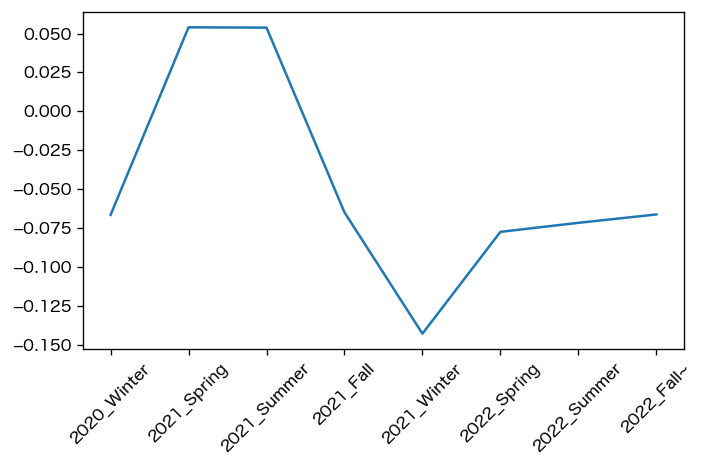

In [68]:
save_path = 'results'
fig,ax = plt.subplots()
ax.tick_params(axis='x', labelrotation=45)
plt.plot(season_data_lst,res_df['linear_weights'].iloc[1:9])
fig.set_dpi(120)
plt.tight_layout()
fig.savefig('/'.join([save_path,'overall_coefs.png']), facecolor='white', transparent=False)

# Plot Portugal vax rate

/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_20084/2819253437.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['people_vaccinated_per_hundred'][i] = tmp_df['people_vaccinated_per_hundred'][i-1]
/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_20084/2819253437.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_df['people_fully_vaccinated_per_hundred'][i]= tmp_df['people_fully_vaccinated_per_hundred'][i-1]
/var/folders/g2/q79cxj1s6d148dc_pt98ggx40000gn/T/ipykernel_20084/2819253437.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See 

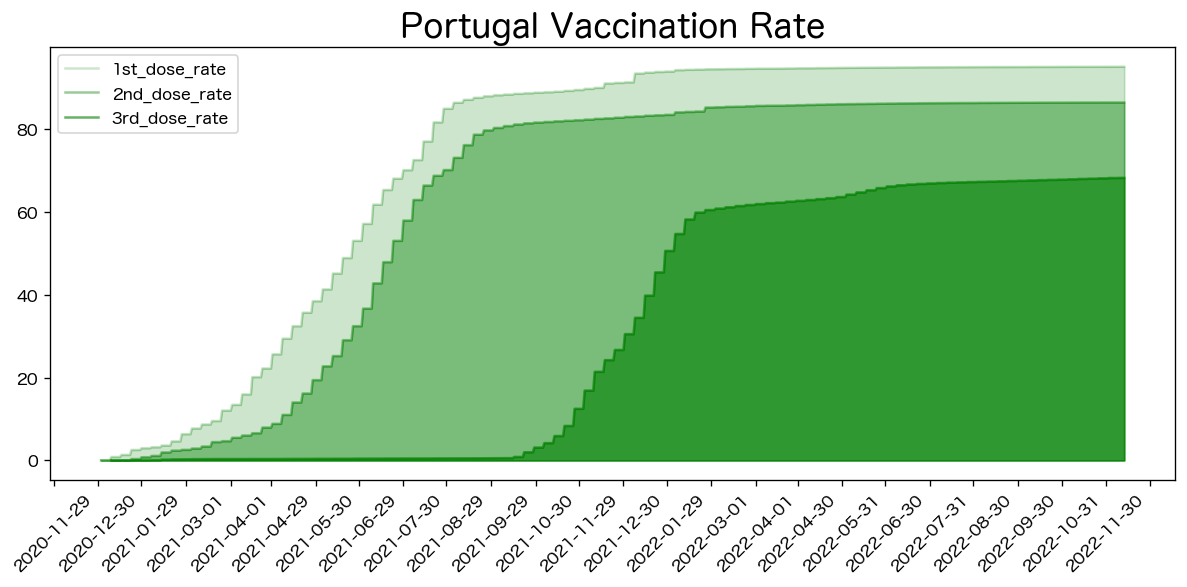

In [507]:
plot_vax_rate(df,'Portugal')

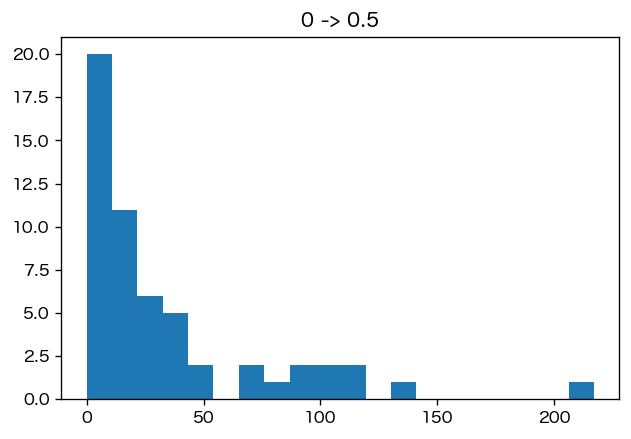

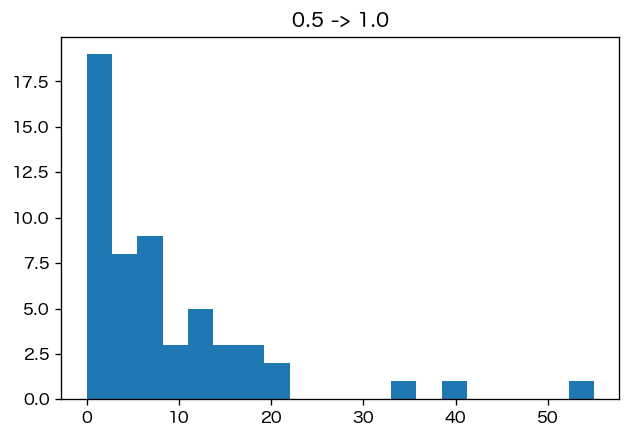

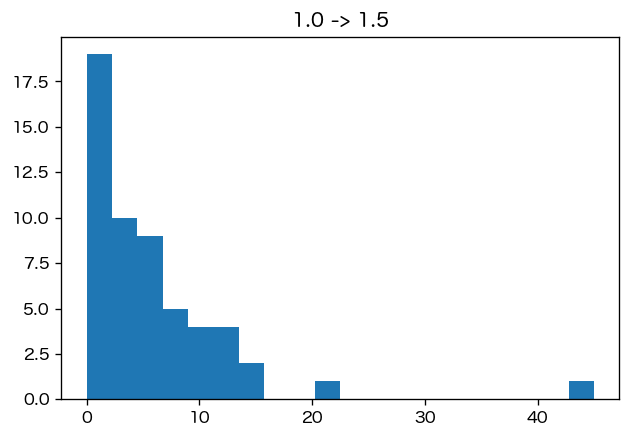

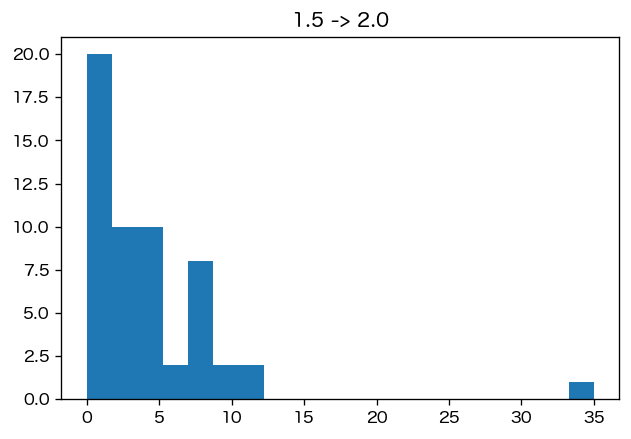

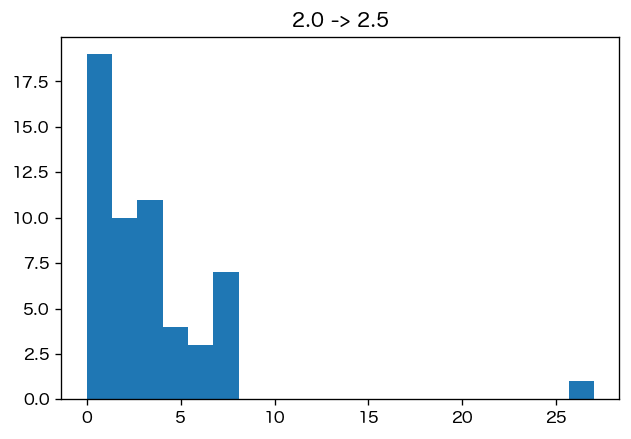

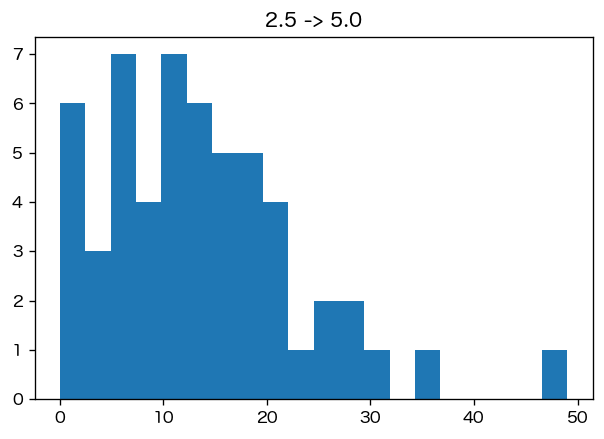

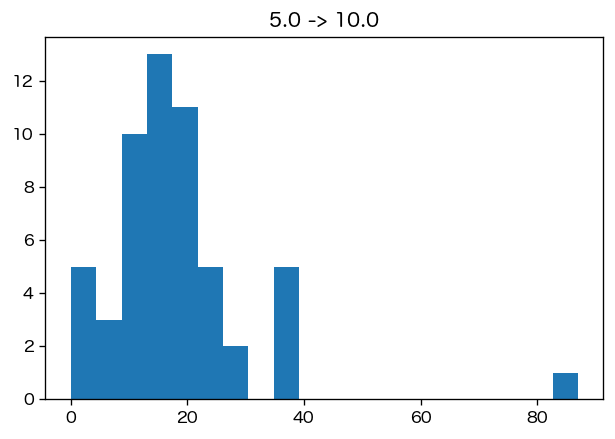

In [983]:
#rate_lst = [0,0.5,1.0,2.0,3.0,4.0,5.0,10.0] #0.5,
rate_lst = [0,0.5,1.0,1.5,2.0,2.5,5.0,10.0] #0.5,

save_path = 'long_tail_histogram'
os.makedirs(save_path,exist_ok=True)
lst_1dose_all = []
lst_2dose_all = []
lst_3dose_all = []


for Countryname in new_df.location.unique().tolist():
    tmp_df=df[df['location']==Countryname].reset_index(drop=True)
    lst_1dose = []
    lst_2dose = []
    lst_3dose = []
    st_per = rate_lst[0]
    for et_per in rate_lst[1:]:
        st_1dose = tmp_df[tmp_df['people_vaccinated_per_hundred']>st_per]['date'].iloc[0]
        et_1dose = tmp_df[tmp_df['people_vaccinated_per_hundred']>=et_per]['date'].iloc[0]
        st = datetime.strptime(st_1dose,'%Y-%m-%d')
        et = datetime.strptime(et_1dose,'%Y-%m-%d')
        lst_1dose.append((et - st).days)
        #print(st_per,et_per,st_1dose,et_1dose,(et - st).days)
        
        st_2dose = tmp_df[tmp_df['people_fully_vaccinated_per_hundred']>st_per]['date'].iloc[0]
        et_2dose = tmp_df[tmp_df['people_fully_vaccinated_per_hundred']>=et_per]['date'].iloc[0]
        st = datetime.strptime(st_2dose,'%Y-%m-%d')
        et = datetime.strptime(et_2dose,'%Y-%m-%d')
        lst_2dose.append((et - st).days)
        #print(st_per,et_per,st_2dose,et_2dose,(et - st).days)

        st_3dose = tmp_df[tmp_df['total_boosters_per_hundred']>st_per]['date'].iloc[0]
        et_3dose = tmp_df[tmp_df['total_boosters_per_hundred']>=et_per]['date'].iloc[0]
        st = datetime.strptime(st_3dose,'%Y-%m-%d')
        et = datetime.strptime(et_3dose,'%Y-%m-%d')
        lst_3dose.append((et - st).days)
        #print(st_per,et_per,st_3dose,et_3dose,(et - st).days)
        st_per = et_per
    #print(Countryname,lst_3dose) #lst_1dose,lst_2dose,
    lst_1dose_all.append((Countryname,lst_1dose))
    lst_2dose_all.append((Countryname,lst_2dose))
    lst_3dose_all.append((Countryname,lst_3dose))

n_dpi=120
for i in range(len(lst_3dose_all[0][1])):
    fig,ax = plt.subplots()
    tmp_lst = [x[1][i] for x in lst_3dose_all]
    plt.hist(tmp_lst,bins=20)
    plt.title('{} -> {}'.format(rate_lst[i],rate_lst[i+1]))
    fig.set_dpi(n_dpi)
    outfig = '{}/3rd_{}->{}.png'.format(save_path,rate_lst[i],rate_lst[i+1])
    fig.savefig(outfig,facecolor='white', transparent=False)

In [984]:
long_3rd_lst = []
for x in lst_3dose_all:
    if x[1][0] >= 60 : 
        long_3rd_lst.append(x[0])
print(long_3rd_lst)
print('Total {} countries >= 60 days.'.format(len(long_3rd_lst)))

['Austria', 'Canada', 'Denmark', 'Estonia', 'France', 'Germany', 'Lithuania', 'Luxembourg', 'Norway', 'Portugal', 'Uruguay']
Total 11 countries >= 60 days.


## Cal mean vax rate of above countries

In [89]:
dose1_rate_lst = []
dose2_rate_lst = []
dose3_rate_lst = []

for Countryname in new_join_df.location.unique().tolist():
    #if Countryname == 'Sweden':
    #    continue
    tmp_df = df[(df['location'] == Countryname)&(df['date']<'2022-06-31')].reset_index(drop=True)
    dose1_rate = tmp_df['people_vaccinated_per_hundred'].max()
    dose2_rate = tmp_df['people_fully_vaccinated_per_hundred'].max()
    dose3_rate = tmp_df['total_boosters_per_hundred'].max()
    dose1_rate_lst.append(dose1_rate)
    dose2_rate_lst.append(dose2_rate)
    dose3_rate_lst.append(dose3_rate)
    #print(Countryname,dose1_rate,dose2_rate,dose3_rate)
print('Average : ', np.mean(dose1_rate_lst),np.mean(dose2_rate_lst),np.mean(dose3_rate_lst))

Average :  77.51254545454546 72.47072727272727 51.98109090909091
